# Preparing a Multi-task Dataset

The dataset we created in Tutorial 2 can be used to train "single-task" models, which are models that predict values for one response variable (in this case, the $pIC_{50}$ for compounds that inhibit the KCNA3 ion
channel). AMPL also enables you to train "multi-task" models that can predict multiple response variables from one set of inputs. This can be beneficial when you have a set of target proteins that are similar structurally or in
some way; features of molecules that predict their actions on one target may predict their actions against 
other targets as well.

In this tutorial, we will encapsulate the steps we performed in Tutorial 2 into a 'curate' function, which we will apply to 3 datasets: our original KCNA3 dataset,
plus similar datasets for the ion channels KCNA5 and SCN5A. We will then combine the curated datasets for the individual targets to produce one "multi-task" dataset.

## Encapsulating the Curation Process
To make it easier to apply the same curation steps to multiple datasets, we define a `curate` function as follows. This function simply calls the AMPL functions
that we used in Tutorial 2:

In [1]:
import os
import pandas as pd

from atomsci.ddm.utils.struct_utils import base_smiles_from_smiles, mol_wt_from_smiles
from atomsci.ddm.utils.data_curation_functions import compute_negative_log_responses, standardize_relations
from atomsci.ddm.utils.curate_data import remove_outlier_replicates, aggregate_assay_data


def curate(df):
     # Standardize SMILES strings
     df['base_rdkit_smiles'] = base_smiles_from_smiles(df.smiles.tolist(), workers=8)
    
     # Filter out compounds with large molecular weights
     df['mol_wt'] = mol_wt_from_smiles(df.base_rdkit_smiles.tolist(), workers=8)
     df = df[df.mol_wt < 2000].copy()

     # Convert IC50s to pIC50s
     df = compute_negative_log_responses(df, 
                              unit_col='standard_units',
                              value_col='standard_value',
                              new_value_col='pIC50',
                              relation_col='standard_relation',
                              unit_conv={'µM':lambda x: x*1e-6, 'nM':lambda x: x*1e-9},
                              inplace=False)
     
     # Standardize relations for censored data
     df = standardize_relations(df, db='ChEMBL', 
                    rel_col='standard_relation',
                    output_rel_col='fixed_relation')

     # Remove outliers
     df = remove_outlier_replicates(df, id_col='molecule_chembl_id',
                                   response_col='pIC50', max_diff_from_median=1.0)

     # Average/aggregate replicate values
     df = aggregate_assay_data(df, 
                              value_col='pIC50',
                              output_value_col='avg_pIC50',
                              id_col='molecule_chembl_id',
                              smiles_col='base_rdkit_smiles',
                              relation_col='fixed_relation',
                              label_actives=False
                         )
     return df

We use this function to curate datasets for three related targets (all ion channel proteins):

In [2]:
for f in ['kcna3_ic50.csv', 'kcna5_ic50.csv', 'scn5a_ic50.csv']:
     print(f'{f}\n')
     df = pd.read_csv(os.path.join('dataset', f))
     print("Original data shape: ", df.shape)
     df = curate(df)
     print("Curated data shape: ", df.shape)
     print(df.columns, '\n')
     df.to_csv('dataset/curated_'+f, index=False)

kcna3_ic50.csv

Original data shape:  (891, 6)
Removed 4 pIC50 replicate measurements that were > 1.0 from median
Curated data shape:  (370, 4)
Index(['compound_id', 'base_rdkit_smiles', 'relation', 'avg_pIC50'], dtype='object') 

kcna5_ic50.csv

Original data shape:  (880, 6)
Removed 1 pIC50 replicate measurements that were > 1.0 from median
Curated data shape:  (802, 4)
Index(['compound_id', 'base_rdkit_smiles', 'relation', 'avg_pIC50'], dtype='object') 

scn5a_ic50.csv

Original data shape:  (2368, 6)
Removed 20 pIC50 replicate measurements that were > 1.0 from median
Curated data shape:  (1827, 4)
Index(['compound_id', 'base_rdkit_smiles', 'relation', 'avg_pIC50'], dtype='object') 



## Combine Single-Task Datasets into One Multi-Task Dataset
We use the `pandas` [merge](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) function to combine the three curated datasets into one:

In [3]:
kcna5 = pd.read_csv('dataset/curated_kcna5_ic50.csv')
kcna3 = pd.read_csv('dataset/curated_kcna3_ic50.csv')
scn5a = pd.read_csv('dataset/curated_scn5a_ic50.csv')

df = kcna5.merge(kcna3, how='outer', on=['compound_id', 'base_rdkit_smiles',], suffixes=['_kcna5', None])
df = df.merge(scn5a, how='outer', on=['compound_id', 'base_rdkit_smiles'], suffixes=['_kcna3', '_scn5a'])
print(df.columns.values)
df.to_csv('dataset/kcna5_kcna3_scna5a.csv', index=False)

['compound_id' 'base_rdkit_smiles' 'relation_kcna5' 'avg_pIC50_kcna5'
 'relation_kcna3' 'avg_pIC50_kcna3' 'relation_scn5a' 'avg_pIC50_scn5a']


In [4]:
df.head()

,compound_id,base_rdkit_smiles,relation_kcna5,avg_pIC50_kcna5,relation_kcna3,avg_pIC50_kcna3,relation_scn5a,avg_pIC50_scn5a
0,CHEMBL1294,C=C[C@H]1CN2CC[C@H]1C[C@@H]2[C@@H](O)c1ccnc2cc...,NaN,5.136677,NaN,NaN,NaN,4.970521
1,CHEMBL4081003,CC(=O)NC(c1ccccc1-c1cc(Cl)cc(Cl)c1)C(c1cccnc1)...,NaN,6.829738,NaN,NaN,NaN,NaN
2,CHEMBL1290619,CC(=O)NCC(C)(C)CN(C1=NS(=O)(=O)c2cc(F)ccc21)c1...,NaN,5.928118,NaN,5.928118,NaN,NaN
3,CHEMBL584507,CC(=O)Nc1ccc2c(c1)nc(C1=C(C)Nc3ccnn3C1c1ccc(Cl...,<,6.000000,NaN,NaN,NaN,NaN
4,CHEMBL1813048,CC(=O)Nc1cccc(Nc2ncnc(N3CCC(OCc4ccc(OC(F)(F)F)...,<,4.477556,NaN,NaN,NaN,5.343971


In the table above, we see NaN's in the avg_pIC50 columns on rows where there are data for some targets but not others. For a multitask dataset, we generally want to have some compounds with data for more than one target. We can plot a Venn diagram to see how many compounds have $pIC_{50}$'s for each pair of targets and for all three.

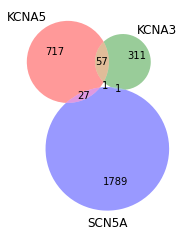

In [5]:
import matplotlib_venn as mpv
_ = mpv.venn3([set(df.loc[df.avg_pIC50_kcna5.notna(), 'base_rdkit_smiles']),
           set(df.loc[df.avg_pIC50_kcna3.notna(), 'base_rdkit_smiles']),
           set(df.loc[df.avg_pIC50_scn5a.notna(), 'base_rdkit_smiles']),],
          set_labels=['KCNA5','KCNA3','SCN5A'])

In this dataset, there is a little overlap between the target-specific compound sets, though not as much as we'd prefer for multitask modeling. Nevertheless,
in a later tutorial we'll use this dataset to demonstrate how to perform a multitask scaffold split and how to train a multitask regression model.